# Dice Detection Training

## 1. Setup & Installation

In [1]:
# Install required packages
!pip install torch torchvision torchaudio --index-url https://download.pytorch.org/whl/cu118

# Install system dependencies for pillow-avif-plugin
!sudo apt-get update
!sudo apt-get install -y libheif-dev libavif-dev

!pip install roboflow matplotlib seaborn tqdm numpy pillow

Looking in indexes: https://download.pytorch.org/whl/cu118
Get:1 https://cli.github.com/packages stable InRelease [3,917 B]
Get:2 https://cloud.r-project.org/bin/linux/ubuntu jammy-cran40/ InRelease [3,632 B]
Get:3 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu2204/x86_64  InRelease [1,581 B]
Get:4 https://cloud.r-project.org/bin/linux/ubuntu jammy-cran40/ Packages [85.0 kB]
Hit:5 http://archive.ubuntu.com/ubuntu jammy InRelease
Get:6 https://cli.github.com/packages stable/main amd64 Packages [356 B]
Get:7 http://security.ubuntu.com/ubuntu jammy-security InRelease [129 kB]
Get:8 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu2204/x86_64  Packages [2,359 kB]
Get:9 http://archive.ubuntu.com/ubuntu jammy-updates InRelease [128 kB]
Get:10 https://r2u.stat.illinois.edu/ubuntu jammy InRelease [6,555 B]
Get:11 https://ppa.launchpadcontent.net/deadsnakes/ppa/ubuntu jammy InRelease [18.1 kB]
Get:12 http://archive.ubuntu.com/ubuntu jammy-backports InRelease [127 

In [2]:
# Clone the git repository with the code
import os
if not os.path.exists('Dice-Detection'):
    !git clone https://github.com/Adr44mo/Dice-Detection.git
    %cd Dice-Detection
else:
    %cd Dice-Detection

# Add src to path
import sys
sys.path.append('./src')

Cloning into 'Dice-Detection'...
remote: Enumerating objects: 98, done.
remote: Counting objects: 100% (98/98), done.
remote: Compressing objects: 100% (65/65), done.
remote: Total 98 (delta 46), reused 83 (delta 31), pack-reused 0 (from 0)
Receiving objects: 100% (98/98), 4.81 MiB | 17.05 MiB/s, done.
Resolving deltas: 100% (46/46), done.
/content/Dice-Detection


## 2. Import Libraries

In [3]:
import torch
import torch.utils.data as data
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path
import json
import os

# Import custom modules
from src.dataset import DiceDetectionDataset, collate_fn
from src.model import get_fasterrcnn_model, save_model_checkpoint, get_fasterrcnn_mobilenet
from src.training import train_one_epoch, evaluate, get_optimizer, get_lr_scheduler
from src.metrics import evaluate_map, print_metrics
from src.augmentation import ClassAwareSampler, MosaicAugmentation, apply_random_augmentations
from src.visualization import (
    plot_class_distribution,
    plot_training_history,
    display_sample_batch,
    visualize_predictions,
    plot_ap_comparison
)

# Import custom loss function for reference
from src.Loss_function import RoIHeadsWithFocalLoss, FocalLoss

print(f"PyTorch version: {torch.__version__}")
print(f"CUDA available: {torch.cuda.is_available()}")
if torch.cuda.is_available():
    print(f"CUDA device: {torch.cuda.get_device_name(0)}")
from src.aug.annotation_manager import AnnotationManager
from src.aug.difficulty_sampling import DifficultyAwareSampler
from src.aug.copy_paste import CopyPasteAugmentation

PyTorch version: 2.9.0+cu126
CUDA available: True
CUDA device: Tesla T4


## 3. Configuration

In [4]:
# =============================================================================
# AUGMENTATION CONFIGURATION
# =============================================================================

#dataset
USE_GAN_DATASET = False


# Sampling
USE_CLASS_AWARE_SAMPLING = False
USE_DIFFICULTY_AWARE_SAMPLING = False
DIFFICULTY_WEIGHT = 0.5

# Augmentation
USE_MOSAIC_AUGMENTATION = True
MOSAIC_PROB = 0.5
USE_RANDOM_AUGMENTATION = False
USE_COPY_PASTE = False
COPY_PASTE_PROB = 0.5

# =============================================================================
# CUSTOM LOSS FUNCTION CONFIGURATION
# =============================================================================

# Enable Focal Loss for class imbalance handling
USE_FOCAL_LOSS = False

# Focal Loss hyperparameters
# alpha: Weighting factor for the rare class (lower = less weight on easy examples)
# gamma: Focusing parameter (higher = more focus on hard examples)
FOCAL_LOSS_ALPHA = 0.25  # Default: 0.25
FOCAL_LOSS_GAMMA = 2.0   # Default: 2.0

# =============================================================================
# ANNOTATION FILES
# =============================================================================
TRAIN_ANNOTATION = 'train_zipfian_object_balanced.coco.json'
VAL_ANNOTATION = 'val_zipfian_object_balanced.coco.json'
TEST_ANNOTATION = 'test_balanced.coco.json'

# =============================================================================
# PRINT CONFIGURATION SUMMARY
# =============================================================================
print("="*60)
print("TRAINING CONFIGURATION")
print("="*60)
print("\n[Augmentation Settings]")
print(f"  Class-Aware Sampling: {'ON' if USE_CLASS_AWARE_SAMPLING else 'OFF'}")
print(f"  Difficulty-Aware Sampling: {'ON' if USE_DIFFICULTY_AWARE_SAMPLING else 'OFF'}")
print(f"  Mosaic Augmentation: {'ON' if USE_MOSAIC_AUGMENTATION else 'OFF'} (prob={MOSAIC_PROB})")
print(f"  Random Augmentation: {'ON' if USE_RANDOM_AUGMENTATION else 'OFF'}")
print(f"  Copy-Paste: {'ON' if USE_COPY_PASTE else 'OFF'}")
print(f"  GAN Dataset: {'ON' if USE_GAN_DATASET else 'OFF'}")

print("\n[Loss Function Settings]")
print(f"  Focal Loss: {'ON' if USE_FOCAL_LOSS else 'OFF (Standard Cross-Entropy)'}")
if USE_FOCAL_LOSS:
    print(f"    Alpha: {FOCAL_LOSS_ALPHA}")
    print(f"    Gamma: {FOCAL_LOSS_GAMMA}")
print("="*60)

TRAINING CONFIGURATION

[Augmentation Settings]
  Class-Aware Sampling: OFF
  Difficulty-Aware Sampling: OFF
  Mosaic Augmentation: ON (prob=0.5)
  Random Augmentation: OFF
  Copy-Paste: OFF
  GAN Dataset: OFF

[Loss Function Settings]
  Focal Loss: OFF (Standard Cross-Entropy)


### Focal Loss Explanation

Standard Cross-Entropy Loss:
$$CE(p, y) = -\log(p_t)$$

Focal Loss:
$$FL(p_t) = -\alpha_t (1 - p_t)^\gamma \log(p_t)$$

Where:
- $p_t$ is the model's estimated probability for the correct class
- $\alpha$ is a weighting factor for class imbalance
- $\gamma$ is the focusing parameter that reduces loss for well-classified examples

**Benefits:**
- Reduces the contribution of easy examples
- Allows the model to focus on hard, misclassified examples
- Particularly useful for object detection with class imbalance

## 4. Download Dataset from Roboflow

In [5]:
from roboflow import Roboflow

# TODO: Add your Roboflow API key
rf = Roboflow(api_key="kd9lS9tvh5StEQtSA6i9")

# Download the dice dataset
project = rf.workspace("workspace-spezm").project("dice-0sexk")
dataset = project.version(2).download("coco")

print(f"Dataset downloaded to: {dataset.location}")

loading Roboflow workspace...
loading Roboflow project...



Extracting Dataset Version Zip to dice-2 in coco:: 100%|██████████| 1467/1467 [00:00<00:00, 8757.61it/s]

Dataset downloaded to: /content/Dice-Detection/dice-2


## 5. Prepare Datasets

### 5.5. Load Custom Annotations

Load annotations from the `Annotations` folder and copy them to the dataset directories.

In [6]:
# Initialize Annotation Manager
anno_manager = AnnotationManager('./Annotations')

print(f'Loading annotations:')
print(f'  Train: {TRAIN_ANNOTATION}')
print(f'  Val: {VAL_ANNOTATION}')
print(f'  Test: {TEST_ANNOTATION}')

# Load selected annotations
train_anno = anno_manager.load_annotation_set(TRAIN_ANNOTATION)
val_anno = anno_manager.load_annotation_set(VAL_ANNOTATION)
test_anno = anno_manager.load_annotation_set(TEST_ANNOTATION)

# Get stats
train_stats = anno_manager.get_dataset_stats(TRAIN_ANNOTATION)
val_stats = anno_manager.get_dataset_stats(VAL_ANNOTATION)
test_stats = anno_manager.get_dataset_stats(TEST_ANNOTATION)

print(f'\nTrain: {train_stats["num_images"]} images, {train_stats["num_annotations"]} annotations')
print(f'Val: {val_stats["num_images"]} images, {val_stats["num_annotations"]} annotations')
print(f'Test: {test_stats["num_images"]} images, {test_stats["num_annotations"]} annotations')

# Set paths (will be defined in next cell)
DATASET_PATH = dataset.location
TRAIN_PATH = os.path.join(DATASET_PATH, "train")
VAL_PATH = os.path.join(DATASET_PATH, "valid")
TEST_PATH = os.path.join(DATASET_PATH, "test")

# Write annotations to dataset paths (override Roboflow annotations)
import shutil
os.makedirs(TRAIN_PATH, exist_ok=True)
os.makedirs(VAL_PATH, exist_ok=True)
os.makedirs(TEST_PATH, exist_ok=True)

with open(os.path.join(TRAIN_PATH, '_annotations.coco.json'), 'w') as f:
    json.dump(train_anno, f)

with open(os.path.join(VAL_PATH, '_annotations.coco.json'), 'w') as f:
    json.dump(val_anno, f)

with open(os.path.join(TEST_PATH, '_annotations.coco.json'), 'w') as f:
    json.dump(test_anno, f)

print('\n✓ Annotations loaded and copied to dataset directories!')
print(f'  Train: {TRAIN_PATH}/_annotations.coco.json')
print(f'  Val: {VAL_PATH}/_annotations.coco.json')
print(f'  Test: {TEST_PATH}/_annotations.coco.json')

Loading annotations:
  Train: train_zipfian_object_balanced.coco.json
  Val: val_zipfian_object_balanced.coco.json
  Test: test_balanced.coco.json

Train: 481 images, 1219 annotations
Val: 85 images, 255 annotations
Test: 104 images, 150 annotations

✓ Annotations loaded and copied to dataset directories!
  Train: /content/Dice-Detection/dice-2/train/_annotations.coco.json
  Val: /content/Dice-Detection/dice-2/valid/_annotations.coco.json
  Test: /content/Dice-Detection/dice-2/test/_annotations.coco.json


In [7]:
# Set dataset paths

# Check if test set exists
has_test_set = os.path.exists(TEST_PATH) and os.path.exists(os.path.join(TEST_PATH, "_annotations.coco.json"))
print(f"Test set available: {has_test_set}")

# Create datasets
train_dataset = DiceDetectionDataset(
    root_dir=TRAIN_PATH,
    annotation_file="_annotations.coco.json",
    split="train"
)

val_dataset = DiceDetectionDataset(
    root_dir=VAL_PATH,
    annotation_file="_annotations.coco.json",
    split="val"
)

# Create test dataset if available
if has_test_set:
    test_dataset = DiceDetectionDataset(
        root_dir=TEST_PATH,
        annotation_file="_annotations.coco.json",
        split="test"
    )
    print(f"Training dataset size: {len(train_dataset)}")
    print(f"Validation dataset size: {len(val_dataset)}")
    print(f"Test dataset size: {len(test_dataset)}")
else:
    test_dataset = None
    print(f"Training dataset size: {len(train_dataset)}")
    print(f"Validation dataset size: {len(val_dataset)}")
    print(f"No test set - will use validation set for final evaluation")

print(f"Number of classes: {train_dataset.num_classes}")

Test set available: True
Training dataset size: 481
Validation dataset size: 85
Test dataset size: 104
Number of classes: 8


## 6. Flexible Augmentation Wrapper

In [8]:
class AugmentedDataset(torch.utils.data.Dataset):
    """Wrapper dataset that applies configured augmentations"""

    def __init__(self, base_dataset, use_mosaic=True, mosaic_prob=0.5, use_random=True, use_copy_paste=False, copy_paste_prob=0.5):
        self.base_dataset = base_dataset
        self.use_mosaic = use_mosaic
        self.use_random = use_random
        self.use_copy_paste = use_copy_paste

        if use_mosaic:
            self.mosaic = MosaicAugmentation(
                base_dataset,
                output_size=(640, 640),
                prob=mosaic_prob
            )
            if use_copy_paste:
                self.copy_paste = CopyPasteAugmentation(
                    base_dataset, prob=copy_paste_prob, num_instances=(1, 3))

    def __len__(self):
        return len(self.base_dataset)

    def __getitem__(self, idx):
        # Apply Mosaic if enabled
        if self.use_mosaic:
            image, target = self.mosaic(idx)
        else:
            image, target = self.base_dataset[idx]

        if self.use_copy_paste:
            self.base_dataset._temp_override = (image, target)
            image, target = self.copy_paste(idx)
            if hasattr(self.base_dataset, '_temp_override'):
                delattr(self.base_dataset, '_temp_override')

        # Convert tensor to PIL if needed for augmentations
        if isinstance(image, torch.Tensor):
            from torchvision.transforms import functional as F
            image = F.to_pil_image(image)

        # Apply Random Augmentations if enabled
        if self.use_random:
            image, target = apply_random_augmentations(image, target)

        # Convert back to tensor
        from torchvision.transforms import ToTensor
        image = ToTensor()(image)

        return image, target

# Create augmented training dataset based on config
augmented_train_dataset = AugmentedDataset(
    train_dataset,
    use_mosaic=USE_MOSAIC_AUGMENTATION,
    mosaic_prob=MOSAIC_PROB,
    use_random=USE_RANDOM_AUGMENTATION,
    use_copy_paste=USE_COPY_PASTE,
    copy_paste_prob=COPY_PASTE_PROB
)

print(f"Created dataset wrapper with:")
print(f"  Mosaic: {USE_MOSAIC_AUGMENTATION}")
print(f"  Random Augmentations: {USE_RANDOM_AUGMENTATION}")

Created dataset wrapper with:
  Mosaic: True
  Random Augmentations: False


## 7. Create Data Loaders with Optional Sampling

In [9]:
# Hyperparameters
BATCH_SIZE = 16
NUM_WORKERS = 4
NUM_EPOCHS = 5
LEARNING_RATE = 0.005
DEVICE = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

# Configure Sampler
if USE_DIFFICULTY_AWARE_SAMPLING and USE_CLASS_AWARE_SAMPLING:
    print('Both samplers on, using Difficulty-Aware')
    USE_CLASS_AWARE_SAMPLING = False

if USE_DIFFICULTY_AWARE_SAMPLING:
    train_sampler = DifficultyAwareSampler(
        train_dataset, samples_per_epoch=len(train_dataset) * 2,
        difficulty_weight=DIFFICULTY_WEIGHT)
    shuffle = False
    print('Difficulty-Aware sampler created')
elif USE_CLASS_AWARE_SAMPLING:
    train_sampler = ClassAwareSampler(
        train_dataset, samples_per_epoch=len(train_dataset) * 2)
    shuffle = False
    print('Class-Aware sampler created')
else:
    train_sampler = None
    shuffle = True
    print('No sampler created')

# Create data loaders
train_loader = data.DataLoader(
    augmented_train_dataset,
    batch_size=BATCH_SIZE,
    shuffle=shuffle,
    sampler=train_sampler,
    num_workers=NUM_WORKERS,
    collate_fn=collate_fn
)

val_loader = data.DataLoader(
    val_dataset,
    batch_size=BATCH_SIZE,
    shuffle=False,
    num_workers=NUM_WORKERS,
    collate_fn=collate_fn
)

print(f"Training batches: {len(train_loader)}")
print(f"Validation batches: {len(val_loader)}")

No sampler created
Training batches: 31
Validation batches: 6


This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.


## 8. Initialize Model with Custom Loss Function

In [10]:
# Create model with optional Focal Loss
print(f"Creating model with Focal Loss: {USE_FOCAL_LOSS}")

"""model = get_fasterrcnn_mobilenet(
    num_classes=train_dataset.num_classes,
    pretrained=True,
    trainable_backbone_layers=3,
    use_focal_loss=USE_FOCAL_LOSS,
    alpha=FOCAL_LOSS_ALPHA,
    gamma=FOCAL_LOSS_GAMMA
)"""
model = get_fasterrcnn_model(
    num_classes=train_dataset.num_classes,
    pretrained=True,
    trainable_backbone_layers=3,
    use_focal_loss=USE_FOCAL_LOSS,
    alpha=FOCAL_LOSS_ALPHA,
    gamma=FOCAL_LOSS_GAMMA
)

model.to(DEVICE)

# Setup optimizer and scheduler
optimizer = get_optimizer(model, lr=LEARNING_RATE)
lr_scheduler = get_lr_scheduler(optimizer, step_size=3, gamma=0.1)

print(f"Model initialized on {DEVICE}")
if USE_FOCAL_LOSS:
    print(f"  Using Focal Loss (alpha={FOCAL_LOSS_ALPHA}, gamma={FOCAL_LOSS_GAMMA})")
    print(f"  RoI Heads type: {type(model.roi_heads).__name__}")
else:
    print(f"  Using Standard Cross-Entropy Loss")

Creating model with Focal Loss: False
Downloading: "https://download.pytorch.org/models/fasterrcnn_resnet50_fpn_coco-258fb6c6.pth" to /root/.cache/torch/hub/checkpoints/fasterrcnn_resnet50_fpn_coco-258fb6c6.pth


100%|██████████| 160M/160M [00:01<00:00, 124MB/s]


Model initialized on cuda
  Using Standard Cross-Entropy Loss


### Verify Custom Loss Function Setup

In [11]:
# Verify the loss function is properly configured
if USE_FOCAL_LOSS:
    print("Verifying Focal Loss configuration...")
    print(f"  Model RoI Heads: {type(model.roi_heads).__name__}")

    if hasattr(model.roi_heads, 'focal_loss'):
        fl = model.roi_heads.focal_loss
        print(f"  ✓ Focal Loss attached to RoI Heads")
        print(f"    Alpha: {fl.alpha}")
        print(f"    Gamma: {fl.gamma}")
        print(f"    Reduction: {fl.reduction}")
    else:
        print("  ⚠ Warning: Focal Loss not found in RoI Heads")
else:
    print("Standard Cross-Entropy Loss is being used.")

Standard Cross-Entropy Loss is being used.


## 9. Training Loop

In [12]:
# Training history
history = {
    'train_loss': [],
    'val_loss': [],
    'learning_rate': []
}

best_val_loss = float('inf')

# Include focal loss in checkpoint directory name
loss_str = f"fl{int(USE_FOCAL_LOSS)}" if USE_FOCAL_LOSS else "ce"
CHECKPOINT_DIR = f"checkpoints_comparison_{loss_str}"
os.makedirs(CHECKPOINT_DIR, exist_ok=True)

print("Starting training...")
print(f"Checkpoint directory: {CHECKPOINT_DIR}\n")

Starting training...
Checkpoint directory: checkpoints_comparison_ce



In [13]:
for epoch in range(NUM_EPOCHS):
    print(f"\n{'='*60}")
    print(f"Epoch {epoch + 1}/{NUM_EPOCHS}")
    print(f"{'='*60}")

    # Train
    train_metrics = train_one_epoch(
        model, optimizer, train_loader, DEVICE, epoch + 1
    )

    # Evaluate
    val_metrics = evaluate(model, val_loader, DEVICE)

    # Update learning rate
    lr_scheduler.step()

    # Record history
    history['train_loss'].append(train_metrics['loss'])
    history['val_loss'].append(val_metrics['val_loss'])
    history['learning_rate'].append(optimizer.param_groups[0]['lr'])

    # Print summary
    print(f"\nEpoch {epoch + 1} Summary:")
    print(f"  Train Loss: {train_metrics['loss']:.4f}")
    print(f"  Val Loss: {val_metrics['val_loss']:.4f}")
    print(f"  Learning Rate: {optimizer.param_groups[0]['lr']:.6f}")
    print(f"  Time: {train_metrics['time']:.2f}s")

    # Generate config string for filenames (include focal loss info)
    config_str = f"ca{int(USE_CLASS_AWARE_SAMPLING)}_mo{int(USE_MOSAIC_AUGMENTATION)}_rn{int(USE_RANDOM_AUGMENTATION)}_fl{int(USE_FOCAL_LOSS)}"

    # Save best model
    if val_metrics['val_loss'] < best_val_loss:
        best_val_loss = val_metrics['val_loss']
        checkpoint_path = os.path.join(CHECKPOINT_DIR, f"best_model_{config_str}.pth")
        save_model_checkpoint(
            model, optimizer, epoch + 1, val_metrics['val_loss'],
            checkpoint_path,
            additional_info={
                'train_loss': train_metrics['loss'],
                'config': config_str,
                'use_focal_loss': USE_FOCAL_LOSS,
                'focal_alpha': FOCAL_LOSS_ALPHA if USE_FOCAL_LOSS else None,
                'focal_gamma': FOCAL_LOSS_GAMMA if USE_FOCAL_LOSS else None
            }
        )
        print(f"  ✓ New best model saved!")

    # Save latest checkpoint
    latest_path = os.path.join(CHECKPOINT_DIR, f"latest_model_{config_str}.pth")
    save_model_checkpoint(
        model, optimizer, epoch + 1, val_metrics['val_loss'],
        latest_path
    )

print("\n" + "="*60)
print("Training completed!")
print("="*60)


Epoch 1/5


Epoch 1:  32%|███▏      | 10/31 [00:35<00:59,  2.83s/it]

  Batch [10/31] Loss: 1.5699 (Cls: 0.8306, Box: 0.6297, Obj: 0.0707, RPN: 0.0388)


Epoch 1:  65%|██████▍   | 20/31 [01:03<00:31,  2.88s/it]

  Batch [20/31] Loss: 1.3150 (Cls: 0.6371, Box: 0.5917, Obj: 0.0460, RPN: 0.0402)


Epoch 1:  97%|█████████▋| 30/31 [01:32<00:02,  2.86s/it]

  Batch [30/31] Loss: 1.1320 (Cls: 0.5471, Box: 0.5134, Obj: 0.0337, RPN: 0.0377)


Evaluating: 100%|██████████| 6/6 [00:07<00:00,  1.29s/it]



Epoch 1 Summary:
  Train Loss: 1.1005
  Val Loss: 0.4202
  Learning Rate: 0.005000
  Time: 93.31s
Checkpoint saved to checkpoints_comparison_ce/best_model_ca0_mo1_rn0_fl0.pth
  ✓ New best model saved!
Checkpoint saved to checkpoints_comparison_ce/latest_model_ca0_mo1_rn0_fl0.pth

Epoch 2/5


Epoch 2:  32%|███▏      | 10/31 [00:32<01:02,  2.97s/it]

  Batch [10/31] Loss: 0.6549 (Cls: 0.3492, Box: 0.2623, Obj: 0.0079, RPN: 0.0356)


Epoch 2:  65%|██████▍   | 20/31 [01:01<00:31,  2.90s/it]

  Batch [20/31] Loss: 0.6333 (Cls: 0.3442, Box: 0.2467, Obj: 0.0079, RPN: 0.0345)


Epoch 2:  97%|█████████▋| 30/31 [01:30<00:02,  2.82s/it]

  Batch [30/31] Loss: 0.5910 (Cls: 0.3275, Box: 0.2261, Obj: 0.0069, RPN: 0.0306)


Evaluating: 100%|██████████| 6/6 [00:07<00:00,  1.33s/it]



Epoch 2 Summary:
  Train Loss: 0.5956
  Val Loss: 0.2842
  Learning Rate: 0.005000
  Time: 90.52s
Checkpoint saved to checkpoints_comparison_ce/best_model_ca0_mo1_rn0_fl0.pth
  ✓ New best model saved!
Checkpoint saved to checkpoints_comparison_ce/latest_model_ca0_mo1_rn0_fl0.pth

Epoch 3/5


Epoch 3:  32%|███▏      | 10/31 [00:32<01:02,  2.99s/it]

  Batch [10/31] Loss: 0.4541 (Cls: 0.2500, Box: 0.1716, Obj: 0.0042, RPN: 0.0283)


Epoch 3:  65%|██████▍   | 20/31 [01:01<00:31,  2.86s/it]

  Batch [20/31] Loss: 0.4272 (Cls: 0.2318, Box: 0.1666, Obj: 0.0040, RPN: 0.0247)


Epoch 3:  97%|█████████▋| 30/31 [01:29<00:02,  2.83s/it]

  Batch [30/31] Loss: 0.4048 (Cls: 0.2186, Box: 0.1598, Obj: 0.0037, RPN: 0.0227)


Evaluating: 100%|██████████| 6/6 [00:08<00:00,  1.38s/it]



Epoch 3 Summary:
  Train Loss: 0.4073
  Val Loss: 0.3032
  Learning Rate: 0.000500
  Time: 90.19s
Checkpoint saved to checkpoints_comparison_ce/latest_model_ca0_mo1_rn0_fl0.pth

Epoch 4/5


Epoch 4:  32%|███▏      | 10/31 [00:33<01:02,  2.97s/it]

  Batch [10/31] Loss: 0.3974 (Cls: 0.2164, Box: 0.1546, Obj: 0.0047, RPN: 0.0216)


Epoch 4:  65%|██████▍   | 20/31 [01:02<00:31,  2.86s/it]

  Batch [20/31] Loss: 0.3659 (Cls: 0.1972, Box: 0.1418, Obj: 0.0042, RPN: 0.0228)


Epoch 4:  97%|█████████▋| 30/31 [01:30<00:02,  2.82s/it]

  Batch [30/31] Loss: 0.3423 (Cls: 0.1859, Box: 0.1306, Obj: 0.0037, RPN: 0.0221)


Evaluating: 100%|██████████| 6/6 [00:08<00:00,  1.38s/it]



Epoch 4 Summary:
  Train Loss: 0.3467
  Val Loss: 0.1619
  Learning Rate: 0.000500
  Time: 90.94s
Checkpoint saved to checkpoints_comparison_ce/best_model_ca0_mo1_rn0_fl0.pth
  ✓ New best model saved!
Checkpoint saved to checkpoints_comparison_ce/latest_model_ca0_mo1_rn0_fl0.pth

Epoch 5/5


Epoch 5:  32%|███▏      | 10/31 [00:33<01:03,  3.02s/it]

  Batch [10/31] Loss: 0.3116 (Cls: 0.1696, Box: 0.1195, Obj: 0.0032, RPN: 0.0193)


Epoch 5:  65%|██████▍   | 20/31 [01:02<00:31,  2.88s/it]

  Batch [20/31] Loss: 0.3110 (Cls: 0.1694, Box: 0.1197, Obj: 0.0033, RPN: 0.0186)


Epoch 5:  97%|█████████▋| 30/31 [01:31<00:02,  2.85s/it]

  Batch [30/31] Loss: 0.3192 (Cls: 0.1719, Box: 0.1240, Obj: 0.0036, RPN: 0.0197)


Evaluating: 100%|██████████| 6/6 [00:07<00:00,  1.28s/it]



Epoch 5 Summary:
  Train Loss: 0.3152
  Val Loss: 0.1476
  Learning Rate: 0.000500
  Time: 91.56s
Checkpoint saved to checkpoints_comparison_ce/best_model_ca0_mo1_rn0_fl0.pth
  ✓ New best model saved!
Checkpoint saved to checkpoints_comparison_ce/latest_model_ca0_mo1_rn0_fl0.pth

Training completed!


## 10. Plot Training History

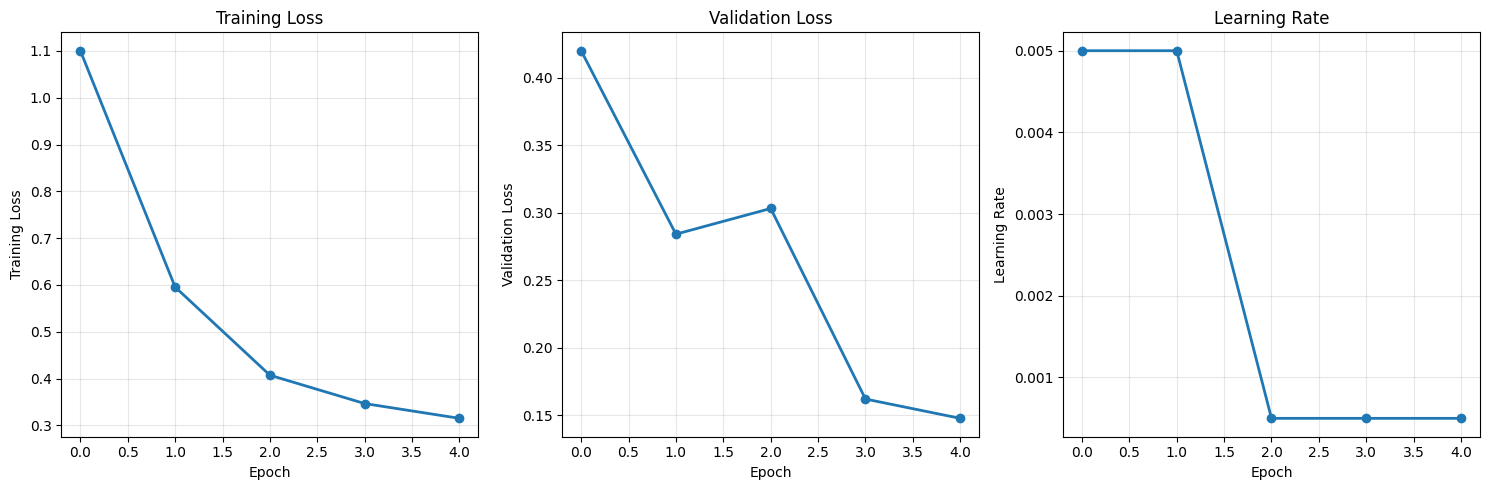

In [14]:
plot_training_history({
    'Training Loss': history['train_loss'],
    'Validation Loss': history['val_loss'],
    'Learning Rate': history['learning_rate']
})

## 11. Final Evaluation

In [15]:
# Prepare evaluation dataset and loader
eval_dataset = test_dataset if has_test_set else val_dataset
eval_loader = data.DataLoader(
    eval_dataset,
    batch_size=BATCH_SIZE,
    shuffle=False,
    num_workers=NUM_WORKERS,
    collate_fn=collate_fn
)

print(f"Evaluating on: {'Test' if has_test_set else 'Validation'} set")

# Load best model for this config
config_str = f"ca{int(USE_CLASS_AWARE_SAMPLING)}_mo{int(USE_MOSAIC_AUGMENTATION)}_rn{int(USE_RANDOM_AUGMENTATION)}_fl{int(USE_FOCAL_LOSS)}"
best_checkpoint_path = os.path.join(CHECKPOINT_DIR, f"best_model_{config_str}.pth")
best_checkpoint = torch.load(best_checkpoint_path)
model.load_state_dict(best_checkpoint['model_state_dict'])
model.to(DEVICE)

print(f"Loaded best model from epoch {best_checkpoint['epoch']}")
if 'use_focal_loss' in best_checkpoint:
    print(f"  Focal Loss: {best_checkpoint['use_focal_loss']}")

# Evaluate
detailed_results = evaluate_map(
    model, eval_loader, DEVICE,
    iou_threshold=0.5,
    confidence_threshold=0.05
)

print("\nDetailed Results at IoU=0.5:")
print_metrics(detailed_results, class_names=eval_dataset.categories)

Evaluating on: Test set
Loaded best model from epoch 5
  Focal Loss: False

Detailed Results at IoU=0.5:

Evaluation Metrics
mAP@0.5: 0.5425
--------------------------------------------------
  1: 0.5116
  2: 0.6111
  3: 0.4018
  4: 0.5314
  5: 0.4945
  6: 0.7046

